# 경쟁하면서 학습하는 GAN

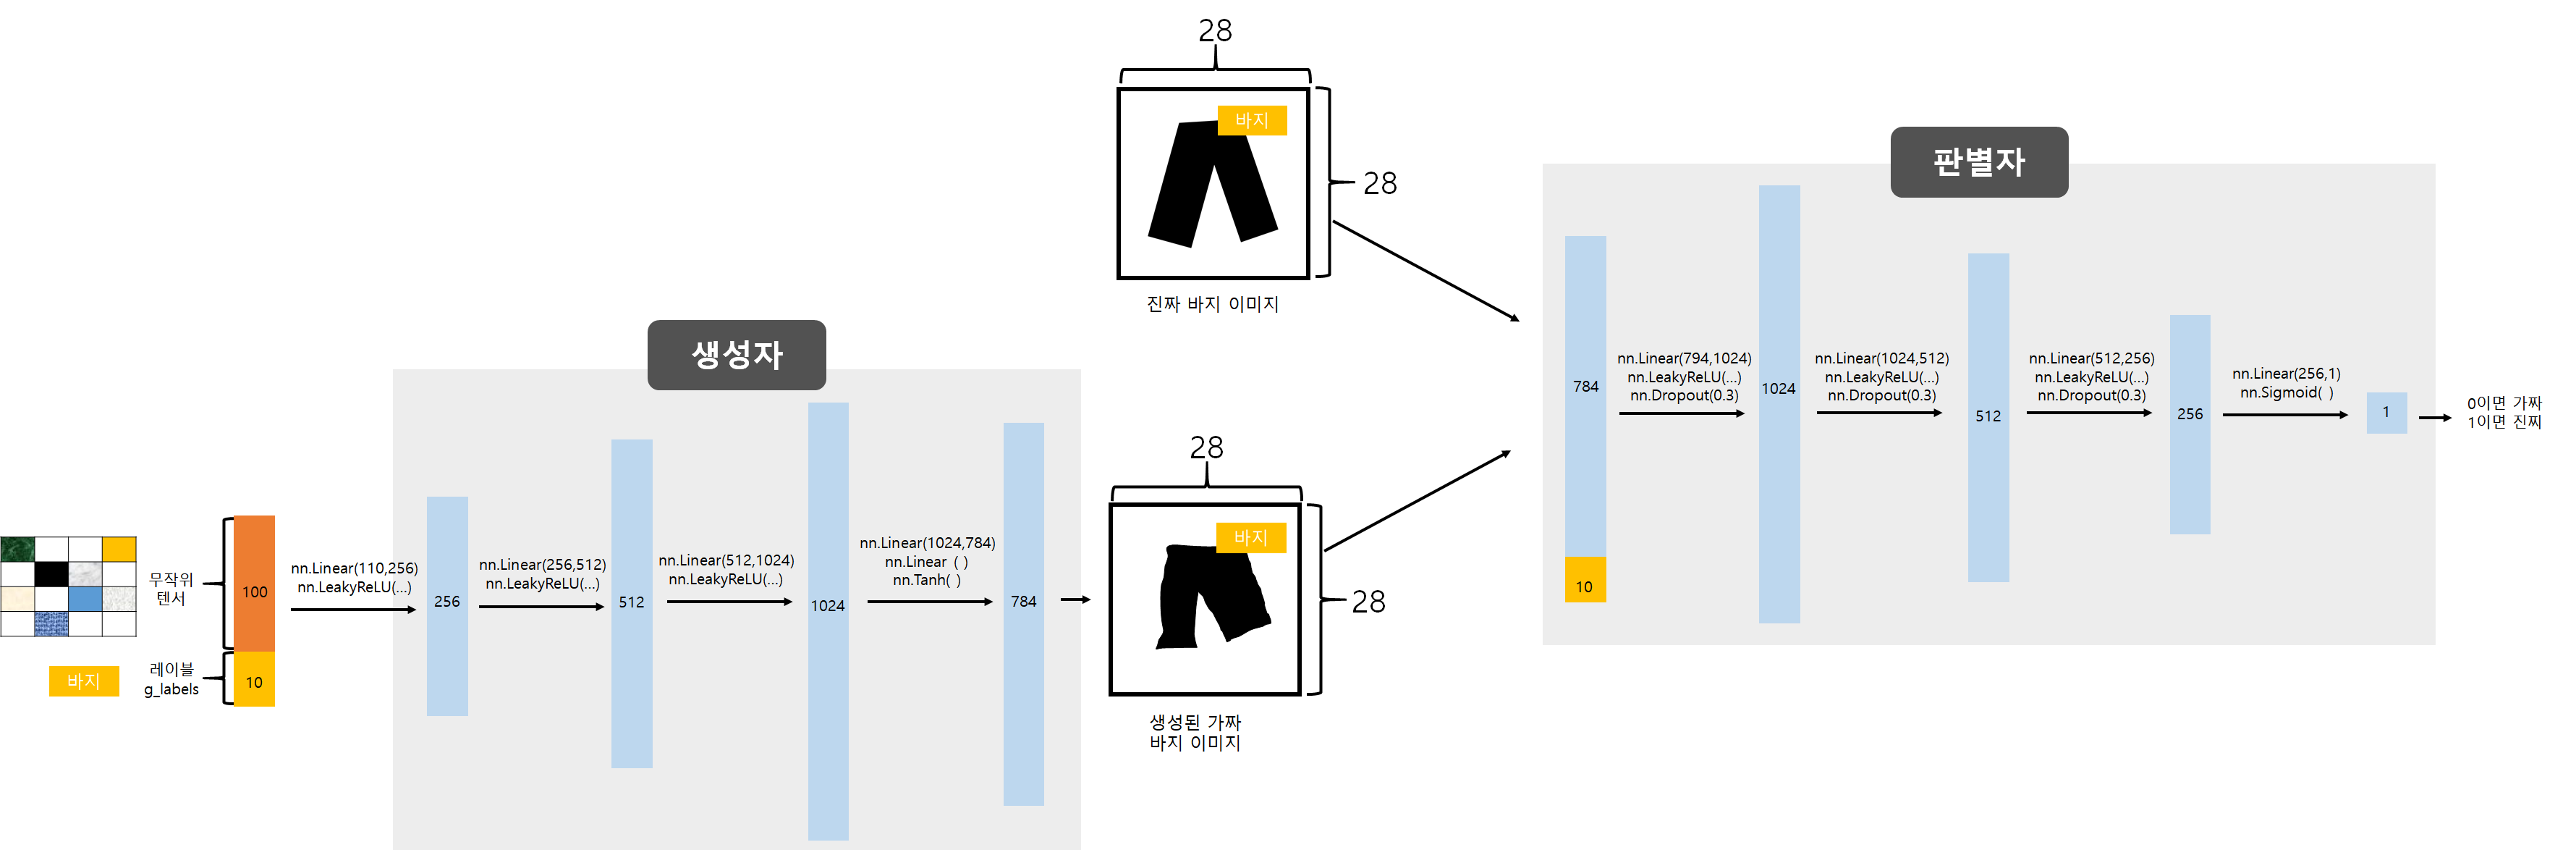

# 필요한 라이브러리 임포트

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# 하이퍼파라미터 설정

In [2]:
#하이퍼파라미터 
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다.: ",DEVICE)


다음 장치를 사용합니다.:  cpu


# 데이터 셋

학습에 필요한 데이터셋


In [3]:
trainset = datasets.FashionMNIST('./.data',
    train= True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ]
    )
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

# 생성자와 판별자 구별

Sequential 클래스는 신경망을 이루는 각 층에서 수행할 연산들을 입력받아 차례대로 실행하는 역할을 한다.

파이토치 모듈의 __init__() 과 forward() 함수를 동시에 정의 



# 생성자

첫 계층 입력값 110 = 무작위 텐서의 크기가 100 + 레이블 정보 10 

cGAN의 생성자는 무작위로 생성한 레이블 정보를 받아 해당 레이블에 대한 이미지를 생성하도록 학습한다.

c = self.embed(labels) 
배치 * 1 크기의 레이블 텐서를 받아아서 배치 * 10  의 연속적인 텐서로 전환한다.
똑같은 레이블은 항상 똑같은 텐서를 만들기 때문에 단순히 연속적인 텐서를 레이블값에 단순 대임 (매핑) 

nn.LeakyReLU(0.2, inplace = True)
-> 입력을 복사하지 않고 바로 조작

x = torch.cat([z,c],1)
-> 무작위 벡턴와 클래스 레이블을 이어 붙임

In [4]:
# 생성자 
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10,10)
        
        self.model =  nn.Sequential(
            nn.Linear(110,256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2, inplace =True),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2, inplace =True),
            nn.Linear(1024,784),
            nn.Tanh(),
        )

    def forward(self, z , labels):
        c = self.embed(labels)
        x = torch.cat([z,c],1)
        return self.model(x)

# 판별자

판별자에게도 레이블 정보를 전달하기 위햇 이미지 크기 784에 10을 더한다.


In [5]:
# 판별자
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10,10)
        
        self.model = nn.Sequential(
            nn.Linear(794,1024),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid()
            )
        
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x,c],1)
        return self.model(x)

# GAN 학습 구현 

모델의 인스턴스를 만든다.
그리고 모델의 가중치를 지정한 장치로 보낸다

In [6]:
# 모델의 가중치를 지정한 장치로 보내기 

D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)


#이진 교차 엔트로피 오차 함수와 
# 생성자와 판별자를 최적화할 Adam 모듈

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(),lr = 0.0002)

# GAN 학습



In [ ]:
# GAN을 학습시키는 반복문 
total_stap = len(train_loader)
for epoch in range(EPOCHS):
    for  i,(images,labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        #진짜와 가짜 레이블 생성 
        real_labels = torch.ones(BATCH_SIZE,1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE,1).to(DEVICE)
        
        #판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images,labels) # 실제 이미지를 신경망에 입력해서 결과를 얻음
        d_loss_real = criterion(outputs, real_labels) # 오차 계산 
        real_score = outputs  # 실제 이미지의 오차값
        
        #무작위 텐서로 가짜 이미지 생성 
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0,10,(BATCH_SIZE,)).to(DEVICE)
        # 무작위 텐서를 생성하는데, torch.randint 로 0과 10 사이의 값을 가진 
        # '배치x 1'크기의 텐서를 하나 만들고, g_label일고 이름을 짓는다. 
        fake_images = G(z,g_label) #생성자에 z, g_label 를 입력해  관계성을 학습  
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        output = D(fake_images,g_label)
        d_loss_fake = criterion(output, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자으 오차 계산
        d_loss = d_loss_real + d_loss_fake  
        
        #역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자 판별자를 속였는지에 대한 오차 계산 (무작위 레이블 입력 )
        fake_images = G(z,g_label)
        outputs = D(fake_images,g_label)
        g_loss = criterion ( outputs, real_labels )
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행 
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss:{:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
         .format(epoch, EPOCHS, d_loss.item(), g_loss.item(),
                real_score.mean().item(), fake_score.mean().item()))
    

이폭 [0/300] d_loss:0.3697 g_loss:6.4942 D(x):0.87 D(G(z)):0.87
이폭 [1/300] d_loss:0.5656 g_loss:3.3150 D(x):0.86 D(G(z)):0.86
이폭 [2/300] d_loss:0.6313 g_loss:4.1858 D(x):0.87 D(G(z)):0.87
이폭 [3/300] d_loss:0.3302 g_loss:3.6329 D(x):0.90 D(G(z)):0.90
이폭 [4/300] d_loss:0.6355 g_loss:2.4295 D(x):0.90 D(G(z)):0.90
이폭 [5/300] d_loss:0.6098 g_loss:2.7892 D(x):0.79 D(G(z)):0.79
이폭 [6/300] d_loss:0.9422 g_loss:1.5650 D(x):0.72 D(G(z)):0.72
이폭 [7/300] d_loss:0.7702 g_loss:2.0450 D(x):0.74 D(G(z)):0.74
이폭 [8/300] d_loss:0.6446 g_loss:2.0214 D(x):0.77 D(G(z)):0.77
이폭 [9/300] d_loss:0.7943 g_loss:1.5147 D(x):0.76 D(G(z)):0.76
이폭 [10/300] d_loss:0.9494 g_loss:1.7005 D(x):0.71 D(G(z)):0.71
이폭 [11/300] d_loss:0.8117 g_loss:1.8160 D(x):0.72 D(G(z)):0.72
이폭 [12/300] d_loss:0.9629 g_loss:1.7202 D(x):0.69 D(G(z)):0.69
이폭 [13/300] d_loss:0.9015 g_loss:1.6802 D(x):0.69 D(G(z)):0.69
이폭 [14/300] d_loss:0.7366 g_loss:2.0172 D(x):0.74 D(G(z)):0.74
이폭 [15/300] d_loss:0.7172 g_loss:1.9074 D(x):0.74 D(G(z)):0.74
이폭

# 결과물 시각화

아이템 번호를 골라 item_number 변수에 저장한다. 그리고 무작위 텐서 z와 레이블 정보 g_label은 하나의 이미지만 출력하기 위해 배치 크기를 1로 지정한다.

 torch.full() 함수는 새로운 텐서를 만드는 함수.
 첫 번째 인수로 텐서의 크기 두번째 인수로 텐서 워소들을 초기화할 값을 받아 g_label 이라는 1차원 텐서를 생선한다.
 
 G_label 텐서는 아까 지정한 아이템 번호를 담고 ㅌ있다.
 
 생성자 G 에 무작위 텐서와 g_label 을 입력해 이밎를 ㄹ생성한 후 sample_images에 담는다.
 
 그리고 파이토치 텐서를 시각가화하기 위해 넘파이 행렬로 바꾼 후 imshow()함수를 이용해 시각화한다. 

In [ ]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 #아이템 번호 
z = torch.randn(1,100).to(DEVICE)#배치 크기 1
g_label = torch.full((1,),item_number, dtype = torch.long).to(DEVICE)
sample_images = G(z,g_label)
sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0],(28,28))
plt.show(sample_images_img, cmap = 'gray')
plt.show()